# Titanic Kaggle Competition

<center><img src="titanic-anniversary-sai-2-embed-02.jpg" alt="Titanic" width="500" height="600""></center>

## Introduction

This project is in association with the Kaggle Titanic Competition.  The goal of this project is to process a dataset of the passengers of the ill-fated voyage of the Titanic and build a binary classifier to determine whether a passenger survives.  

### Imports

In [1]:
import numpy as np
import tensorflow as tf

# Random Seed
np.random.seed(30)
tf.random.set_seed(30)

In [2]:
# The standards
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
import shap
shap.initjs()

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB, MultinomialNB
from sklearn.svm import SVC

# Model Validation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score, f1_score

# Make pandas display all columns
pd.set_option('display.max_columns', None)

# Sklearn Display
from sklearn import set_config
set_config(display = 'diagram')


Bad key "text.kerning_factor" on line 4 in
/Users/spags/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Functions

In [3]:
def get_info(df):
    print('-----  Shape  -----')
    print(df.shape)
    print('\n')
    print('-----  Info  -----')
    print(df.info())
    print('\n')
    print('-----  Describe  -----')
    print(df.describe())
    print('\n')
    print('-----  Nulls  -----')
    print(df.isna().sum())
    
    
def evaluate_model(model, X_test, y_test):
    '''Evaluates a sklearn classifier model by displaying a classification report, 
    a confusion matrix plot, and a ROC-AUC plot.'''
    
    # Predictions
    y_hat_test = model.predict(X_test)
    
    # Classification Report
    print('                 Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_test, y_hat_test))
    
    # Confusion Matrix
    fig, axes = plt.subplots(figsize = (12,6), ncols = 2)
    plot_confusion_matrix(model, X_test, y_test, normalize = 'true',
                          cmap = 'Blues', ax = axes[0])#, labels = ['Survived', 'Died'])
    axes[0].set_title('Confusion Matrix');
    
    # ROC-AUC Curve
    roc_auc_plot = plot_roc_curve(model, X_test, y_test, ax = axes[1])
    axes[1].legend()
    axes[1].plot([0,1], [0,1], ls = ':')
    axes[1].grid()
    axes[1].set_title('ROC-AUC Plot')
    fig.tight_layout()
    plt.show();
    

def network_eval_plots(results):
    '''Visualizes the loss and accuracy curves of the training set and validation set.'''
    
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show();
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show();
    

def nn_confusion_matrix(y_test, preds):
    '''Creates a confusion matrix specifically for neural networks.'''

    cm = confusion_matrix(y_test, preds, normalize = 'true')
    ax = plt.figure(figsize = (6, 6))
    ax = sns.heatmap(cm, cmap = 'Blues', annot = True,
                     xticklabels = ['Died', 'Survived'],
                     yticklabels = ['Died', 'Survived'])
    ax.set_ylim([0,2])
    
    
def evaluate_network(results, model, X_test, y_test):
    preds = model.predict(X_test).round()
    print('                 Model Evaluation')
    print('-------------------------------------------------------')
    print(model.evaluate(X_test, y_test))
    print(' ')
    print('                 Loss & Accuracy Curves')
    print('-------------------------------------------------------')
    network_eval_plots(results)
    print(' ')
    print('                 Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_test, preds))
    print(' ')    
    print('                 Confusion Matrix')
    print('-------------------------------------------------------')
    nn_confusion_matrix(y_test, preds)
    

def sklearn_model(model, X_train, y_train, X_test, y_test):
    sklearn_model = model()
    sklearn_model.fit(X_train, y_train)
    
    # Predictions
    y_hat_test = sklearn_model.predict(X_test)
    
    # Classification Report
    print('                 Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_test, y_hat_test))
    
    # Confusion Matrix
    fig, axes = plt.subplots(figsize = (12,6), ncols = 2)
    plot_confusion_matrix(sklearn_model, X_test, y_test, normalize = 'true',
                          cmap = 'Blues', ax = axes[0])#, labels = ['Survived', 'Died'])
    axes[0].set_title('Confusion Matrix');
    
    # ROC-AUC Curve
    roc_auc_plot = plot_roc_curve(sklearn_model, X_test, y_test, ax = axes[1])
    axes[1].legend()
    axes[1].plot([0,1], [0,1], ls = ':')
    axes[1].grid()
    axes[1].set_title('ROC-AUC Plot')
    fig.tight_layout()
    plt.show();
    

def neural_network(X_train, y_train, X_test, y_test, epochs, batch_size):
    # Model
    model = Sequential()
    model.add(Dense(128, input_shape = X_train.shape, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(8, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    #Compile
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')
    # Fit
    history = model.fit(X_train_df, y_train, batch_size = batch_size, epochs = epochs,
                        validation_split = 0.3)
    
    # Evaluate
    preds = model.predict(X_test).round()
    print('                 Model Evaluation')
    print('-------------------------------------------------------')
    print(model.evaluate(X_test, y_test))
    print(' ')
    print('                 Loss & Accuracy Curves')
    print('-------------------------------------------------------')
    network_eval_plots(history)
    print(' ')
    print('                 Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_test, preds))
    print(' ')    
    print('                 Confusion Matrix')
    print('-------------------------------------------------------')
    nn_confusion_matrix(y_test, preds)

## Obtain

### Training Data

In [4]:
# Create dataframe for training data

train_df = pd.read_csv('train.csv')
print(train_df.shape)
train_df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Test Data

In [5]:
# Create dataframe for test data

test_df = pd.read_csv('test.csv')
print(test_df.shape)
test_df.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Scrub

> Just a quick exploration here to see what we're working with.

In [6]:
# Let's check out the data real quick

display(test_df.head())
display(train_df.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# Get some info on the training data

get_info(train_df)

-----  Shape  -----
(891, 12)


-----  Info  -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


-----  Describe  -----
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0

In [8]:
# Get some info on the test data

get_info(test_df)

-----  Shape  -----
(418, 11)


-----  Info  -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


-----  Describe  -----
       PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0

In [9]:
# Can drop the passenger id column

train_df.drop('PassengerId', axis = 1, inplace = True)
test_df.drop('PassengerId', axis = 1, inplace = True)

### Null Values

In [10]:
# Check the number of null values of the training data

train_df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [11]:
# Check the number of null values of the test data


test_df.isna().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

### Feature Selection & Engineering

#### Cabin

In [12]:
# Let's check out the values of the Cabin column

train_df['Cabin'].value_counts().sort_values(ascending = False) 

B96 B98        4
C23 C25 C27    4
G6             4
F2             3
C22 C26        3
              ..
D56            1
C110           1
T              1
C104           1
C91            1
Name: Cabin, Length: 147, dtype: int64

In [13]:
# Fill the null values in Cabin with 'Missing'

train_df['Cabin'].fillna(value = 'Missing', inplace = True)
train_df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin         0
Embarked      2
dtype: int64

In [14]:
# Create a new column 'Cabin Level' with just the letter associated with the cabin

cabin_level = []
for i in train_df['Cabin']:
    i = str(i)
    i = i[0]
    cabin_level.append(i)
    
train_df['Cabin Level'] = cabin_level

# Drop the cabin column
train_df.drop('Cabin', axis = 1, inplace = True)

# Make sure this all worked!
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin Level
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,M
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,M
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,M


#### Parch & SibSp

In [15]:
# Check the Parch values

train_df['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [16]:
# Check the SibSp values

train_df['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [17]:
#  Create a new column called Family Size

train_df['Family Size'] = train_df['Parch'] + train_df['SibSp'] + 1
train_df['Family Size'].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: Family Size, dtype: int64

In [18]:
# Make Sure this worked

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin Level,Family Size
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,M,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,2
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,M,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C,2
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,M,1


#### Name

> So this could be interesting.  We can make the assumption that each full name on the Titanic is unique.  However, if we were to slice out just the last name, we could see if there is any correlation between last name (family) and survival.

In [19]:
# Checking the assumption that each name is unique.

train_df['Name'].value_counts()

Turcin, Mr. Stjepan                                1
Svensson, Mr. Johan                                1
Lang, Mr. Fang                                     1
Romaine, Mr. Charles Hallace ("Mr C Rolmane")      1
Jerwan, Mrs. Amin S (Marie Marthe Thuillard)       1
                                                  ..
Allison, Mrs. Hudson J C (Bessie Waldo Daniels)    1
Perkin, Mr. John Henry                             1
Cacic, Mr. Luka                                    1
Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")       1
Goodwin, Miss. Lillian Amy                         1
Name: Name, Length: 891, dtype: int64

##### Title

In [20]:
# Create a function to get just the title from the name

def get_titles(column):
    titles = []
    for name in train_df['Name']:
        name = name.split(',')[1]
        name = name.split('.')[0]
        titles.append(name)
        
    return titles

In [21]:
# Create the titles column

train_df['Title'] = get_titles(train_df['Name'])
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin Level,Family Size,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,M,2,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,2,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,M,1,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C,2,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,M,1,Mr


In [22]:
# Checking the titles value counts

train_df['Title'].value_counts()

 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Mlle              2
 Major             2
 Col               2
 Lady              1
 Ms                1
 Sir               1
 Don               1
 Jonkheer          1
 the Countess      1
 Capt              1
 Mme               1
Name: Title, dtype: int64

##### Last Name

In [23]:
# Create a function to get just the last names

def get_last_names(column):
    last_names = []
    for name in column:
        name = name.split(',')[0]
        last_names.append(name)

    return last_names

In [24]:
# Create Last Name and drop name

train_df['Last Name'] = get_last_names(train_df['Name'])
train_df.drop('Name', axis = 1, inplace = True)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin Level,Family Size,Title,Last Name
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S,M,2,Mr,Braund
1,1,1,female,38.0,1,0,PC 17599,71.2833,C,C,2,Mrs,Cumings
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,M,1,Miss,Heikkinen
3,1,1,female,35.0,1,0,113803,53.1000,S,C,2,Mrs,Futrelle
4,0,3,male,35.0,0,0,373450,8.0500,S,M,1,Mr,Allen


In [25]:
# Do the same to the test data

test_df['Last Name'] = get_last_names(test_df['Name'])
test_df.drop('Name', axis = 1, inplace = True)
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last Name
0,3,male,34.5,0,0,330911,7.8292,NaN,Q,Kelly
1,3,female,47.0,1,0,363272,7.0000,NaN,S,Wilkes
2,2,male,62.0,0,0,240276,9.6875,NaN,Q,Myles
3,3,male,27.0,0,0,315154,8.6625,NaN,S,Wirz
4,3,female,22.0,1,1,3101298,12.2875,NaN,S,Hirvonen


In [26]:
# Check value counts

print(train_df['Last Name'].value_counts())
print(test_df['Last Name'].value_counts())

Andersson    9
Sage         7
Goodwin      6
Johnson      6
Carter       6
            ..
Sedgwick     1
Gillespie    1
Parrish      1
Kalvik       1
Albimona     1
Name: Last Name, Length: 667, dtype: int64
Davies               4
Asplund              4
Thomas               4
Ware                 4
Sage                 4
                    ..
Watt                 1
Mardirosian          1
Schmidt              1
Sadowitz             1
Pallas y Castello    1
Name: Last Name, Length: 352, dtype: int64


> As expected, there are multiple people with the same last name, potentially indicating full families on board.

#### Ticket

In [27]:
# Checking the values in the Ticket column

train_df['Ticket'].value_counts()

CA. 2343    7
1601        7
347082      7
347088      6
CA 2144     6
           ..
370371      1
350029      1
371060      1
4579        1
364499      1
Name: Ticket, Length: 681, dtype: int64

In [28]:
for i in train_df['Ticket']:
    print(i)

A/5 21171
PC 17599
STON/O2. 3101282
113803
373450
330877
17463
349909
347742
237736
PP 9549
113783
A/5. 2151
347082
350406
248706
382652
244373
345763
2649
239865
248698
330923
113788
349909
347077
2631
19950
330959
349216
PC 17601
PC 17569
335677
C.A. 24579
PC 17604
113789
2677
A./5. 2152
345764
2651
7546
11668
349253
SC/Paris 2123
330958
S.C./A.4. 23567
370371
14311
2662
349237
3101295
A/4. 39886
PC 17572
2926
113509
19947
C.A. 31026
2697
C.A. 34651
CA 2144
2669
113572
36973
347088
PC 17605
2661
C.A. 29395
S.P. 3464
3101281
315151
C.A. 33111
CA 2144
S.O.C. 14879
2680
1601
348123
349208
374746
248738
364516
345767
345779
330932
113059
SO/C 14885
3101278
W./C. 6608
SOTON/OQ 392086
19950
343275
343276
347466
W.E.P. 5734
C.A. 2315
364500
374910
PC 17754
PC 17759
231919
244367
349245
349215
35281
7540
3101276
349207
343120
312991
349249
371110
110465
2665
324669
4136
2627
STON/O 2. 3101294
370369
11668
PC 17558
347082
S.O.C. 14879
A4. 54510
237736
27267
35281
2651
370372
C 17369
2668
3470

In [29]:
train_df.drop('Ticket', axis = 1, inplace = True)

#### Age Group
> Let's create a categorical age group column.

In [30]:
train_df['Age Group'] = train_df['Age'].copy()

In [31]:
bins = [0, 12, 20, 30, 64, 65]
labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']

train_df['Age Group'] = pd.cut(train_df['Age Group'], bins = bins, labels = labels, right = False)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin Level,Family Size,Title,Last Name,Age Group
0,0,3,male,22.0,1,0,7.2500,S,M,2,Mr,Braund,Young Adult
1,1,1,female,38.0,1,0,71.2833,C,C,2,Mrs,Cumings,Adult
2,1,3,female,26.0,0,0,7.9250,S,M,1,Miss,Heikkinen,Young Adult
3,1,1,female,35.0,1,0,53.1000,S,C,2,Mrs,Futrelle,Adult
4,0,3,male,35.0,0,0,8.0500,S,M,1,Mr,Allen,Adult


### Train Test Split & Preprocessing

In [32]:
# Create X & y

X = train_df.drop('Survived', axis = 1)
y = train_df['Survived']

In [33]:
# Create train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 30)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(668, 12)
(223, 12)
(668,)
(223,)


In [34]:
# Split into numerical and categorical columns

num_cols = X_train.select_dtypes('number').columns
cat_cols = X_train.select_dtypes('O').columns

In [35]:
# Create pipeline for numerical columns

# num_transformer = Pipeline(steps = [('imputer', KNNImputer(n_neighbors = 2)), 
#                                     ('scaler', StandardScaler())])

num_transformer = Pipeline(steps = [('imputer', KNNImputer(n_neighbors = 2)), 
                                    ('scaler', MinMaxScaler())])

num_transformer

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=2)),
                ('scaler', MinMaxScaler())])

In [36]:
# Create pipeline for categorical columns

cat_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'most_frequent')), 
                                    ('encoder', OneHotEncoder(handle_unknown = 'ignore', 
                                                              sparse = False))])
cat_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [37]:
# Combine pipelines into a single pipeline

preprocessing = ColumnTransformer(transformers = [('num', num_transformer, num_cols),
                                                  ('cat', cat_transformer, cat_cols)])

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(n_neighbors=2)),
                                                 ('scaler', MinMaxScaler())]),
                                 Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family Size'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['Sex', 'Embarked', 'Cabin Level', 'Title', 'Last Name'], dtype='object'))])

In [38]:
# Fit the training data with the pipeline

X_train_processed = preprocessing.fit_transform(X_train)
X_test_processed = preprocessing.transform(X_test)

In [39]:
# Put back into a dataframe

slice_pipe = preprocessing.named_transformers_['cat']
cat_features = slice_pipe.named_steps['encoder'].get_feature_names(cat_cols)

In [40]:
# Let's check out what we have

X_train_df = pd.DataFrame(X_train_processed, columns = [*num_cols, *cat_features])
X_test_df = pd.DataFrame(X_test_processed, columns = [*num_cols, *cat_features])

print(X_train_df.shape)
display(X_train_df.head())
print(X_test_df.shape)
display(X_test_df.head())

(668, 568)


,Pclass,Age,SibSp,Parch,Fare,Family Size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cabin Level_A,Cabin Level_B,Cabin Level_C,Cabin Level_D,Cabin Level_E,Cabin Level_F,Cabin Level_G,Cabin Level_M,Cabin Level_T,Title_ Col,Title_ Don,Title_ Dr,Title_ Lady,Title_ Major,Title_ Master,Title_ Miss,Title_ Mlle,Title_ Mme,Title_ Mr,Title_ Mrs,Title_ Ms,Title_ Rev,Title_ Sir,Last Name_Abbing,Last Name_Abbott,Last Name_Abelson,Last Name_Adahl,Last Name_Adams,Last Name_Aks,Last Name_Albimona,Last Name_Alexander,Last Name_Ali,Last Name_Allen,Last Name_Allison,Last Name_Anderson,Last Name_Andersson,Last Name_Andreasson,Last Name_Andrew,Last Name_Angle,Last Name_Appleton,Last Name_Arnold-Franchi,Last Name_Asim,Last Name_Asplund,Last Name_Astor,Last Name_Attalah,Last Name_Aubart,Last Name_Augustsson,Last Name_Ayoub,Last Name_Backstrom,Last Name_Baclini,Last Name_Badt,Last Name_Balkic,Last Name_Ball,Last Name_Banfield,Last Name_Barah,Last Name_Barbara,Last Name_Bateman,Last Name_Baumann,Last Name_Baxter,Last Name_Bazzani,Last Name_Beane,Last Name_Beavan,Last Name_Becker,Last Name_Beckwith,Last Name_Behr,Last Name_Bengtsson,Last Name_Berglund,Last Name_Betros,Last Name_Bidois,Last Name_Birkeland,Last Name_Bishop,Last Name_Bissette,Last Name_Bjornstrom-Steffansson,Last Name_Blackwell,Last Name_Bonnell,Last Name_Boulos,Last Name_Bourke,Last Name_Bowen,Last Name_Bowerman,Last Name_Bracken,Last Name_Bradley,Last Name_Braund,Last Name_Brewe,Last Name_Brocklebank,Last Name_Brown,Last Name_Burke,Last Name_Burns,Last Name_Butler,Last Name_Butt,Last Name_Byles,Last Name_Bystrom,Last Name_Cacic,Last Name_Cairns,Last Name_Calderhead,Last Name_Caldwell,Last Name_Calic,Last Name_Cameron,Last Name_Campbell,Last Name_Cann,Last Name_Carlsson,Last Name_Carr,Last Name_Carrau,Last Name_Carter,Last Name_Cavendish,Last Name_Celotti,Last Name_Chaffee,Last Name_Chambers,Last Name_Chapman,Last Name_Charters,Last Name_Chibnall,Last Name_Chip,Last Name_Christmann,Last Name_Christy,Last Name_Chronopoulos,Last Name_Clarke,Last Name_Cleaver,Last Name_Clifford,Last Name_Coelho,Last Name_Cohen,Last Name_Coleff,Last Name_Coleridge,Last Name_Collander,Last Name_Colley,Last Name_Collyer,Last Name_Compton,Last Name_Connolly,Last Name_Connors,Last Name_Cook,Last Name_Cor,Last Name_Coutts,Last Name_Coxon,Last Name_Crease,Last Name_Cribb,Last Name_Crosby,Last Name_Culumovic,Last Name_Cumings,Last Name_Dahlberg,Last Name_Dakic,Last Name_Daly,Last Name_Danbom,Last Name_Daniel,Last Name_Danoff,Last Name_Dantcheff,Last Name_Davies,Last Name_Davis,Last Name_Davison,Last Name_Dean,Last Name_Denkoff,Last Name_Dennis,Last Name_Devaney,Last Name_Dick,Last Name_Dimic,Last Name_Dodge,Last Name_Doharr,Last Name_Doling,Last Name_Dorking,Last Name_Dowdell,Last Name_Downton,Last Name_Drazenoic,Last Name_Drew,Last Name_Duane,Last Name_Duff Gordon,Last Name_Duran y More,Last Name_Edvardsson,Last Name_Eitemiller,Last Name_Eklund,Last Name_Ekstrom,Last Name_Elias,Last Name_Elsbury,Last Name_Emanuel,Last Name_Emir,Last Name_Endres,Last Name_Eustis,Last Name_Fahlstrom,Last Name_Farrell,Last Name_Farthing,Last Name_Fischer,Last Name_Fleming,Last Name_Flynn,Last Name_Foo,Last Name_Ford,Last Name_Foreman,Last Name_Fortune,Last Name_Francatelli,Last Name_Frauenthal,Last Name_Frolicher,Last Name_Frost,Last Name_Funk,Last Name_Fynney,Last Name_Gaskell,Last Name_Gavey,Last Name_Gee,Last Name_Gheorgheff,Last Name_Giglio,Last Name_Giles,Last Name_Gill,Last Name_Gillespie,Last Name_Gilnagh,Last Name_Givard,Last Name_Glynn,Last Name_Goldenberg,Last Name_Goldschmidt,Last Name_Goldsmith,Last Name_Goncalves,Last Name_Goodwin,Last Name_Graham,Last Name_Greenberg,Last Name_Greenfield,Last Name_Guggenheim,Last Name_Gustafsson,Last Name_Haas,Last Name_Hagland,Last Name_Hakkarainen,Last Name_Hale,Last Name_Hamalainen,Last Name_Hampe,Last Name_Hanna,Last Name_Hansen,Last Name_Harder,Last Name_Harknett,Last Name_Harmer,Last Name_Harper,Last Name_Harrington,Last Name_Harris,Last Name_Harrison,Last Name_Hart,Last 

(223, 568)


,Pclass,Age,SibSp,Parch,Fare,Family Size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cabin Level_A,Cabin Level_B,Cabin Level_C,Cabin Level_D,Cabin Level_E,Cabin Level_F,Cabin Level_G,Cabin Level_M,Cabin Level_T,Title_ Col,Title_ Don,Title_ Dr,Title_ Lady,Title_ Major,Title_ Master,Title_ Miss,Title_ Mlle,Title_ Mme,Title_ Mr,Title_ Mrs,Title_ Ms,Title_ Rev,Title_ Sir,Last Name_Abbing,Last Name_Abbott,Last Name_Abelson,Last Name_Adahl,Last Name_Adams,Last Name_Aks,Last Name_Albimona,Last Name_Alexander,Last Name_Ali,Last Name_Allen,Last Name_Allison,Last Name_Anderson,Last Name_Andersson,Last Name_Andreasson,Last Name_Andrew,Last Name_Angle,Last Name_Appleton,Last Name_Arnold-Franchi,Last Name_Asim,Last Name_Asplund,Last Name_Astor,Last Name_Attalah,Last Name_Aubart,Last Name_Augustsson,Last Name_Ayoub,Last Name_Backstrom,Last Name_Baclini,Last Name_Badt,Last Name_Balkic,Last Name_Ball,Last Name_Banfield,Last Name_Barah,Last Name_Barbara,Last Name_Bateman,Last Name_Baumann,Last Name_Baxter,Last Name_Bazzani,Last Name_Beane,Last Name_Beavan,Last Name_Becker,Last Name_Beckwith,Last Name_Behr,Last Name_Bengtsson,Last Name_Berglund,Last Name_Betros,Last Name_Bidois,Last Name_Birkeland,Last Name_Bishop,Last Name_Bissette,Last Name_Bjornstrom-Steffansson,Last Name_Blackwell,Last Name_Bonnell,Last Name_Boulos,Last Name_Bourke,Last Name_Bowen,Last Name_Bowerman,Last Name_Bracken,Last Name_Bradley,Last Name_Braund,Last Name_Brewe,Last Name_Brocklebank,Last Name_Brown,Last Name_Burke,Last Name_Burns,Last Name_Butler,Last Name_Butt,Last Name_Byles,Last Name_Bystrom,Last Name_Cacic,Last Name_Cairns,Last Name_Calderhead,Last Name_Caldwell,Last Name_Calic,Last Name_Cameron,Last Name_Campbell,Last Name_Cann,Last Name_Carlsson,Last Name_Carr,Last Name_Carrau,Last Name_Carter,Last Name_Cavendish,Last Name_Celotti,Last Name_Chaffee,Last Name_Chambers,Last Name_Chapman,Last Name_Charters,Last Name_Chibnall,Last Name_Chip,Last Name_Christmann,Last Name_Christy,Last Name_Chronopoulos,Last Name_Clarke,Last Name_Cleaver,Last Name_Clifford,Last Name_Coelho,Last Name_Cohen,Last Name_Coleff,Last Name_Coleridge,Last Name_Collander,Last Name_Colley,Last Name_Collyer,Last Name_Compton,Last Name_Connolly,Last Name_Connors,Last Name_Cook,Last Name_Cor,Last Name_Coutts,Last Name_Coxon,Last Name_Crease,Last Name_Cribb,Last Name_Crosby,Last Name_Culumovic,Last Name_Cumings,Last Name_Dahlberg,Last Name_Dakic,Last Name_Daly,Last Name_Danbom,Last Name_Daniel,Last Name_Danoff,Last Name_Dantcheff,Last Name_Davies,Last Name_Davis,Last Name_Davison,Last Name_Dean,Last Name_Denkoff,Last Name_Dennis,Last Name_Devaney,Last Name_Dick,Last Name_Dimic,Last Name_Dodge,Last Name_Doharr,Last Name_Doling,Last Name_Dorking,Last Name_Dowdell,Last Name_Downton,Last Name_Drazenoic,Last Name_Drew,Last Name_Duane,Last Name_Duff Gordon,Last Name_Duran y More,Last Name_Edvardsson,Last Name_Eitemiller,Last Name_Eklund,Last Name_Ekstrom,Last Name_Elias,Last Name_Elsbury,Last Name_Emanuel,Last Name_Emir,Last Name_Endres,Last Name_Eustis,Last Name_Fahlstrom,Last Name_Farrell,Last Name_Farthing,Last Name_Fischer,Last Name_Fleming,Last Name_Flynn,Last Name_Foo,Last Name_Ford,Last Name_Foreman,Last Name_Fortune,Last Name_Francatelli,Last Name_Frauenthal,Last Name_Frolicher,Last Name_Frost,Last Name_Funk,Last Name_Fynney,Last Name_Gaskell,Last Name_Gavey,Last Name_Gee,Last Name_Gheorgheff,Last Name_Giglio,Last Name_Giles,Last Name_Gill,Last Name_Gillespie,Last Name_Gilnagh,Last Name_Givard,Last Name_Glynn,Last Name_Goldenberg,Last Name_Goldschmidt,Last Name_Goldsmith,Last Name_Goncalves,Last Name_Goodwin,Last Name_Graham,Last Name_Greenberg,Last Name_Greenfield,Last Name_Guggenheim,Last Name_Gustafsson,Last Name_Haas,Last Name_Hagland,Last Name_Hakkarainen,Last Name_Hale,Last Name_Hamalainen,Last Name_Hampe,Last Name_Hanna,Last Name_Hansen,Last Name_Harder,Last Name_Harknett,Last Name_Harmer,Last Name_Harper,Last Name_Harrington,Last Name_Harris,Last Name_Harrison,Last Name_Hart,Last 

## Explore

In [41]:
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

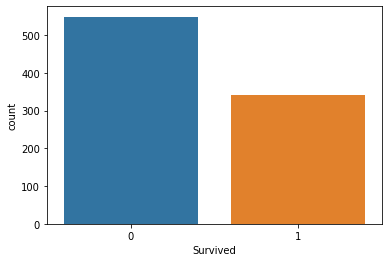

In [42]:
sns.countplot(data = train_df, x = 'Survived');

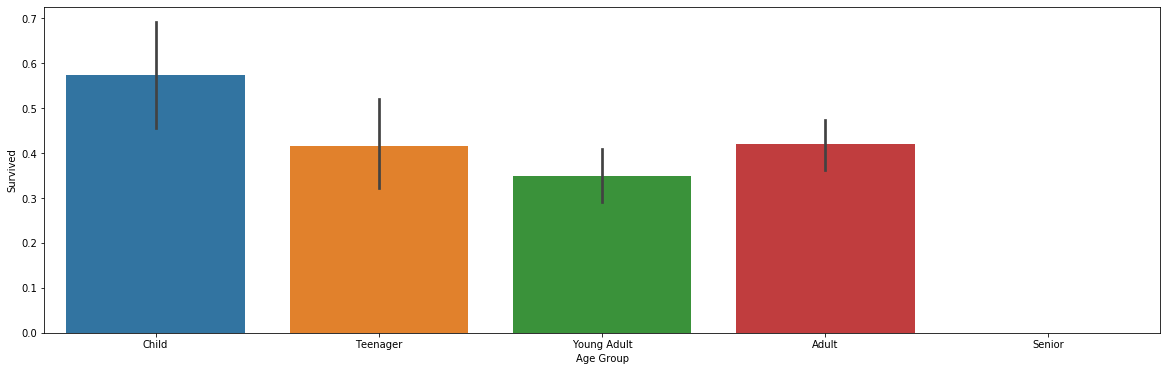

In [43]:
fig = plt.figure(figsize = (20, 6))
fig = sns.barplot(data = train_df, x = 'Age Group', y = 'Survived');

## Modeling

### Logistic Regression

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       131
           1       0.76      0.72      0.74        92

    accuracy                           0.79       223
   macro avg       0.78      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223



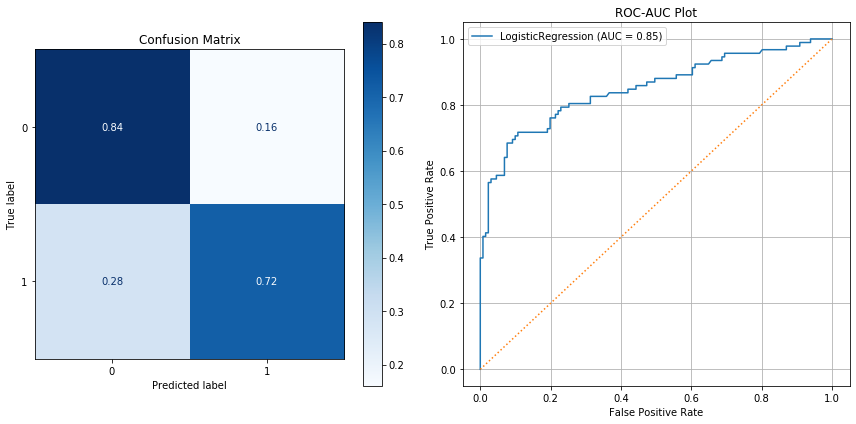

In [44]:
# Fit a base logistic regression model

logreg = LogisticRegression(class_weight = 'balanced')
logreg.fit(X_train_df, y_train)

# Evaluate model
evaluate_model(logreg, X_test_df, y_test)

#### GridSearchCV

In [45]:
# Let's try using gridsearch to see if we can kick this up a notch

params = {'class_weight': ['balanced'],
          'solver' : ['lbfgs', 'liblinear', 'newton-cg'],
          'max_iter': [100, 200, 500],
          'penalty': ['l1', 'l2', 'none']}

logreg_grid = GridSearchCV(estimator = LogisticRegression(),
                           param_grid = params,
                           cv = 3,
                           scoring = 'recall',
                           n_jobs = -1)

logreg_grid.fit(X_train_df, y_train)

print(logreg_grid.best_estimator_.get_params())

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       131
           1       0.76      0.72      0.74        92

    accuracy                           0.79       223
   macro avg       0.78      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223



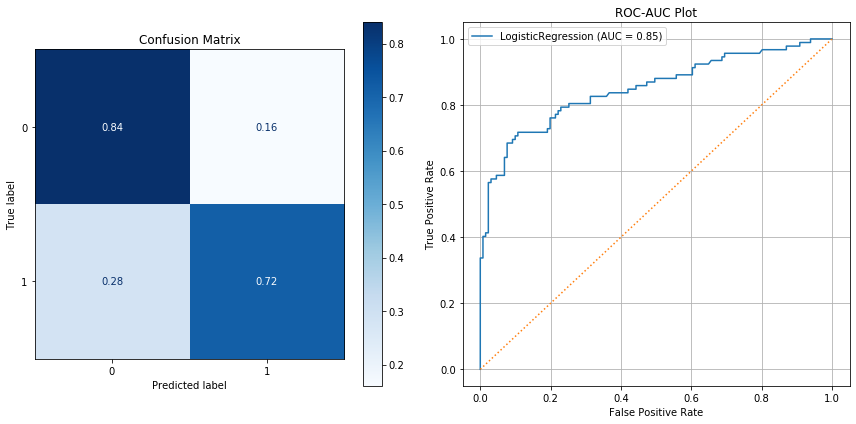

In [46]:
# Fit the model using the best parameters

best_logreg_params = logreg_grid.best_params_
best_logreg_model = LogisticRegression(**best_logreg_params)
best_logreg_model.fit(X_train_df, y_train)

# Evaluate the model
evaluate_model(best_logreg_model, X_test_df, y_test)

### Decision Tree

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       131
           1       0.79      0.70      0.74        92

    accuracy                           0.80       223
   macro avg       0.80      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



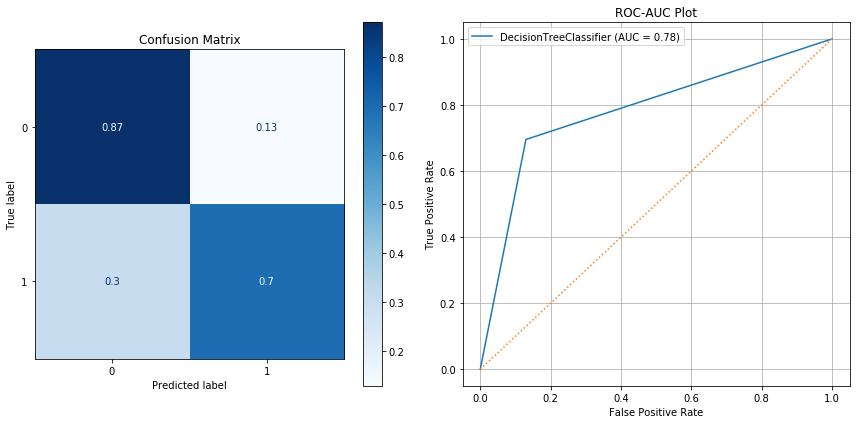

In [47]:
# Fitting a base Decision Tree

tree = DecisionTreeClassifier(class_weight = 'balanced')
tree.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(tree, X_test_df, y_test)

#### GridsearchCV

In [48]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'class_weight' : ['balanced'],
          'splitter' : ['best', 'random'],
          'max_features': [None, "auto", "sqrt", "log2"],
          'criterion': ['gini', 'entropy'],
          'max_depth' : [1, 5, 10, 25], 
          'min_samples_split' : [2, 5, 10],
          'min_samples_leaf' : [1, 5, 10]}

tree_grid = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = params,
                    cv = 3,
                    n_jobs = -1)

tree_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(tree_grid.best_estimator_.get_params())

{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 25, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'random'}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       131
           1       0.79      0.72      0.75        92

    accuracy                           0.80       223
   macro avg       0.80      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223



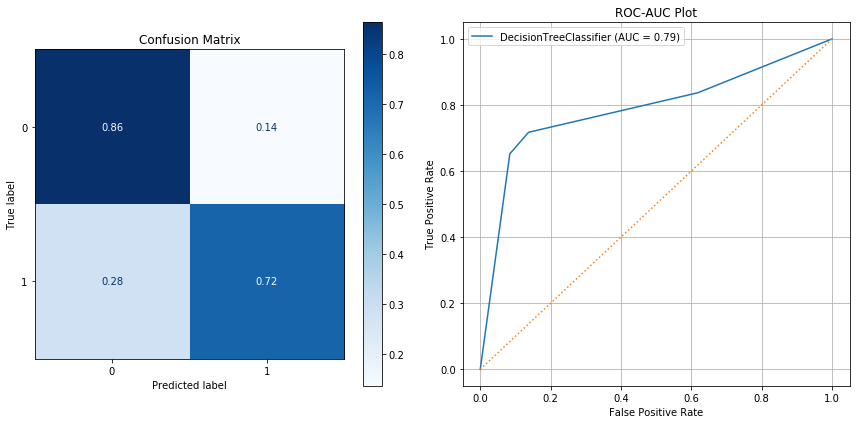

In [49]:
# Fit new model with the best hyperparameters

best_tree_params = tree_grid.best_params_
best_tree_model = DecisionTreeClassifier(**best_tree_params)
best_tree_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_tree_model, X_test_df, y_test)

### KNeighbors Classifier

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       131
           1       0.79      0.70      0.74        92

    accuracy                           0.80       223
   macro avg       0.80      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



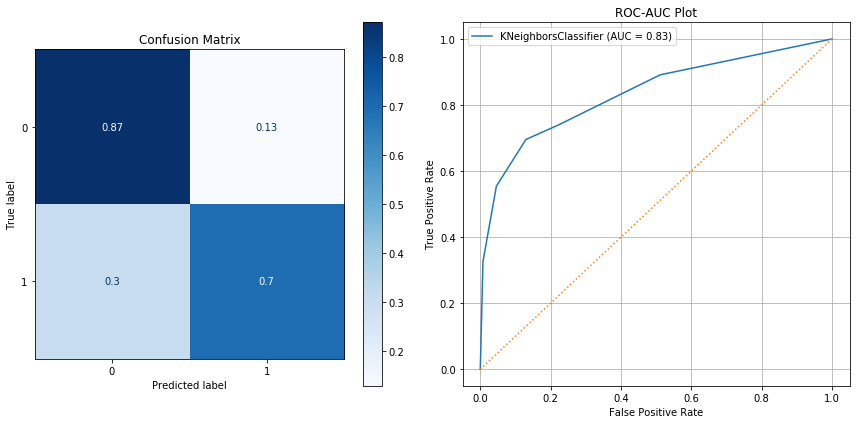

In [50]:
knn = KNeighborsClassifier()
knn.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(knn, X_test_df, y_test)

#### GridsearchCV

In [51]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'n_neighbors' : [1, 2, 3, 4, 5],
          'weights' : ['uniform', 'distance'],
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
          'leaf_size': [10, 30, 50]}

knn_grid = GridSearchCV(estimator = KNeighborsClassifier(),
                    param_grid = params, 
                    cv = 3,
                    n_jobs = -1)

knn_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(knn_grid.best_estimator_.get_params())

{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       131
           1       0.76      0.65      0.70        92

    accuracy                           0.77       223
   macro avg       0.77      0.75      0.76       223
weighted avg       0.77      0.77      0.77       223



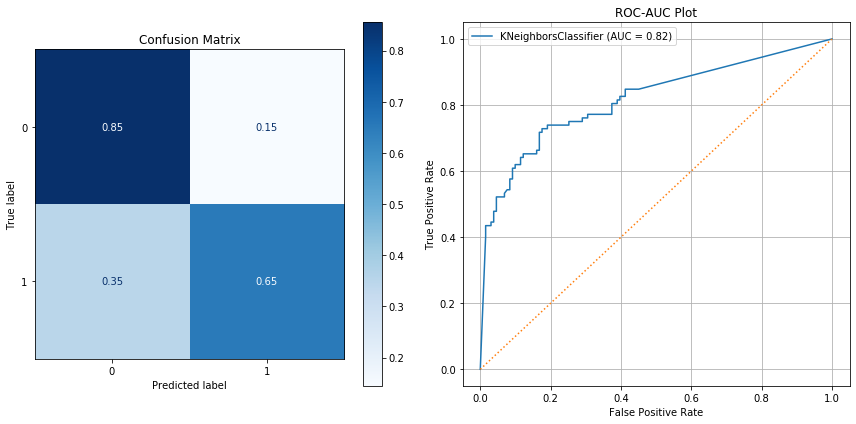

In [52]:
# Fit new model with the best hyperparameters

best_knn_params = knn_grid.best_params_
best_knn_model = KNeighborsClassifier(**best_knn_params)
best_knn_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_knn_model, X_test_df, y_test)

### MLP Classifier

#### Base Model

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       131
           1       0.78      0.67      0.72        92

    accuracy                           0.78       223
   macro avg       0.78      0.77      0.77       223
weighted avg       0.78      0.78      0.78       223



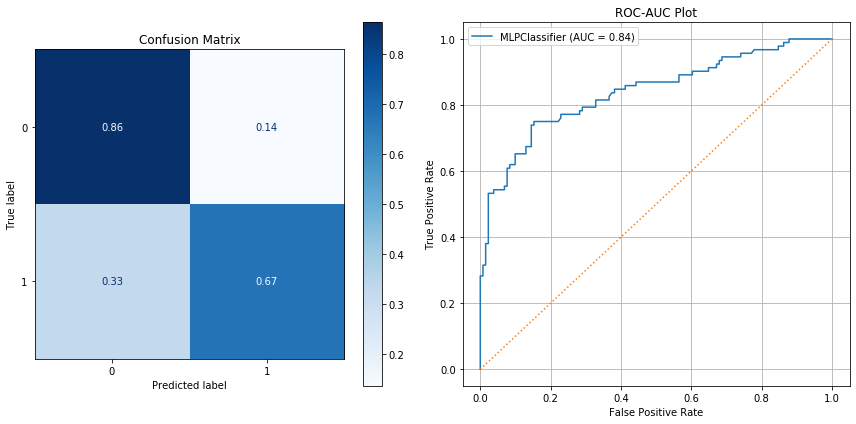

In [53]:
mlp = MLPClassifier()
mlp.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(mlp, X_test_df, y_test)

#### GridsearchCV

In [54]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'hidden_layer_sizes' : [(100,), (200,), (300,)],
          'activation' : ['identity', 'logistic', 'tanh', 'relu'],
          'solver': ['lbfgs', 'sgd', 'adam'],
          'learning_rate': ['constant', 'invscaling', 'adaptive'],
          'early_stopping': [True, False],
          'learning_rate': ['constant', 'invscaling', 'adaptive'],
         }

mlp_grid = GridSearchCV(estimator = MLPClassifier(),
                    param_grid = params, 
                    cv = 3,
                    n_jobs = -1)

mlp_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(mlp_grid.best_estimator_.get_params())

{'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (200,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       131
           1       0.84      0.63      0.72        92

    accuracy                           0.80       223
   macro avg       0.81      0.77      0.78       223
weighted avg       0.80      0.80      0.79       223



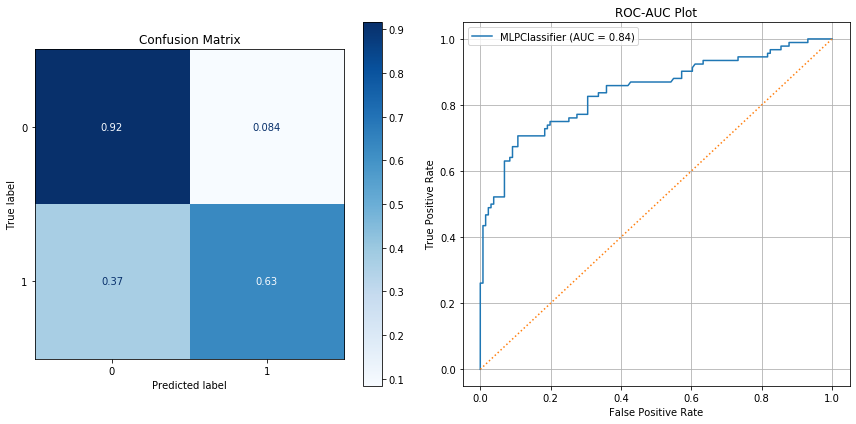

In [55]:
# Fit new model with the best hyperparameters

best_mlp_params = mlp_grid.best_params_
best_mlp_model = MLPClassifier(**best_mlp_params)
best_mlp_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_mlp_model, X_test_df, y_test)

### Guassian Process Classifier

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       131
           1       0.81      0.67      0.73        92

    accuracy                           0.80       223
   macro avg       0.80      0.78      0.79       223
weighted avg       0.80      0.80      0.79       223



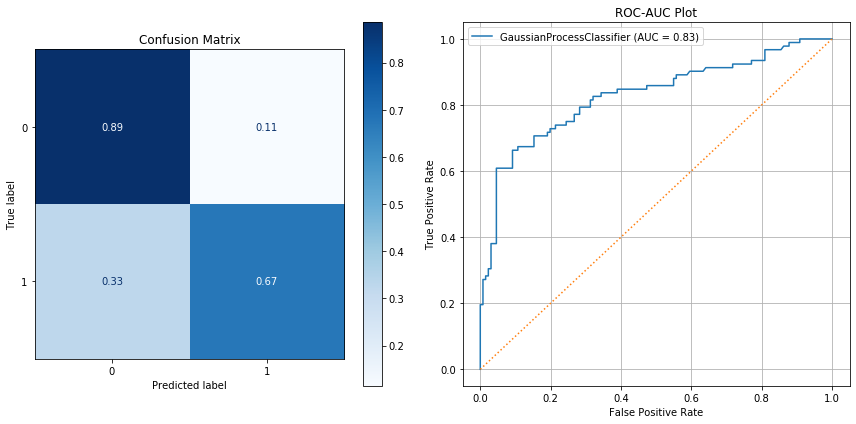

In [56]:
# Base model
gpc = GaussianProcessClassifier()
gpc.fit(X_train_df, y_train)

# Evaluate Model
evaluate_model(gpc, X_test_df, y_test)

#### GridsearchCV

In [57]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'n_restarts_optimizer' : [0, 1, 2],
          'max_iter_predict' : [25, 50, 100, 200]
         }

gcp_grid = GridSearchCV(estimator = GaussianProcessClassifier(),
                    param_grid = params, 
                    cv = 3,
                    n_jobs = -1)

gcp_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(gcp_grid.best_estimator_.get_params())

{'copy_X_train': True, 'kernel': None, 'max_iter_predict': 25, 'multi_class': 'one_vs_rest', 'n_jobs': None, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None, 'warm_start': False}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       131
           1       0.81      0.67      0.73        92

    accuracy                           0.80       223
   macro avg       0.80      0.78      0.79       223
weighted avg       0.80      0.80      0.79       223



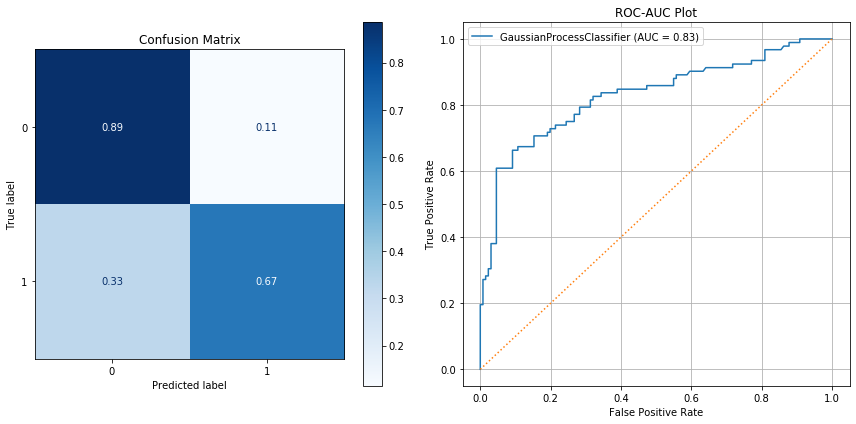

In [58]:
# Fit new model with the best hyperparameters

best_gcp_params = gcp_grid.best_params_
best_gcp_model = GaussianProcessClassifier(**best_gcp_params)
best_gcp_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_gcp_model, X_test_df, y_test)

### Naive Bayes

#### GaussianNB

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.26      0.39       131
           1       0.46      0.89      0.61        92

    accuracy                           0.52       223
   macro avg       0.62      0.58      0.50       223
weighted avg       0.64      0.52      0.48       223



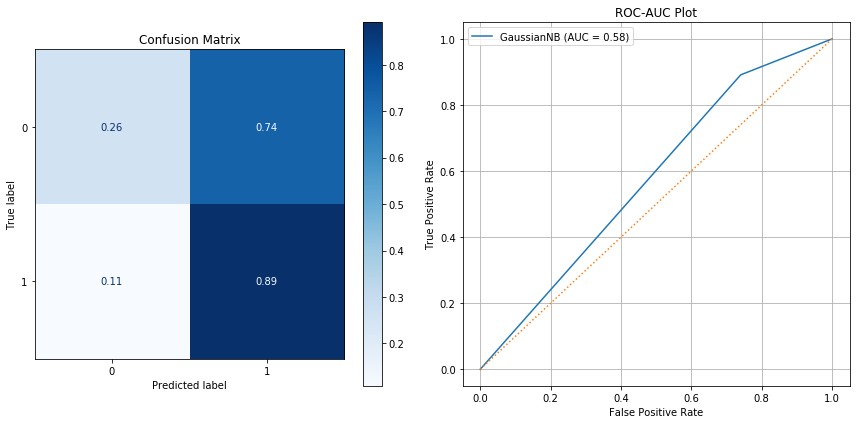

In [59]:
# Fitting a base random forest model

gaussiannb = GaussianNB()
gaussiannb.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(gaussiannb, X_test_df, y_test)

#### BernoulliNB

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       131
           1       0.72      0.68      0.70        92

    accuracy                           0.76       223
   macro avg       0.75      0.75      0.75       223
weighted avg       0.76      0.76      0.76       223



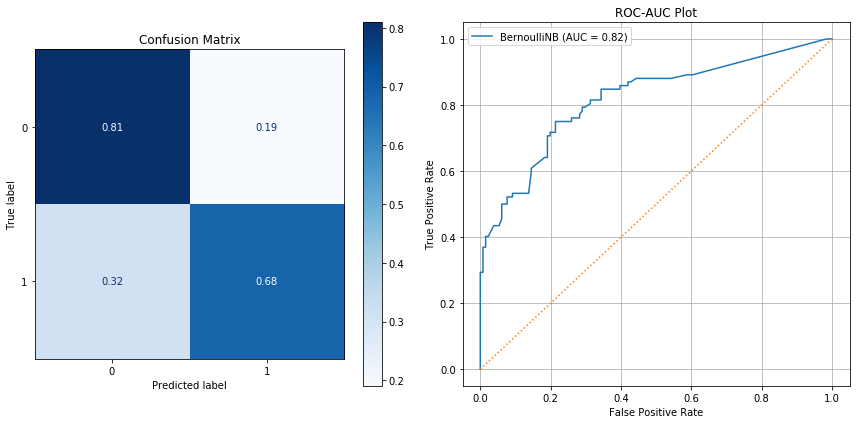

In [60]:
bernoullinb = BernoulliNB()
bernoullinb.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(bernoullinb, X_test_df, y_test)

#### ComplementNB

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       131
           1       0.71      0.67      0.69        92

    accuracy                           0.75       223
   macro avg       0.75      0.74      0.74       223
weighted avg       0.75      0.75      0.75       223



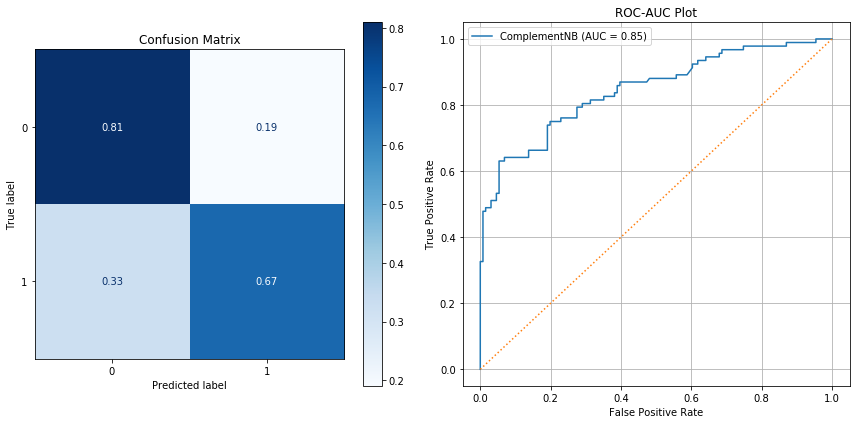

In [61]:
complementnb = ComplementNB()
complementnb.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(complementnb, X_test_df, y_test)

#### MultinomialNB

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       131
           1       0.73      0.66      0.70        92

    accuracy                           0.76       223
   macro avg       0.76      0.75      0.75       223
weighted avg       0.76      0.76      0.76       223



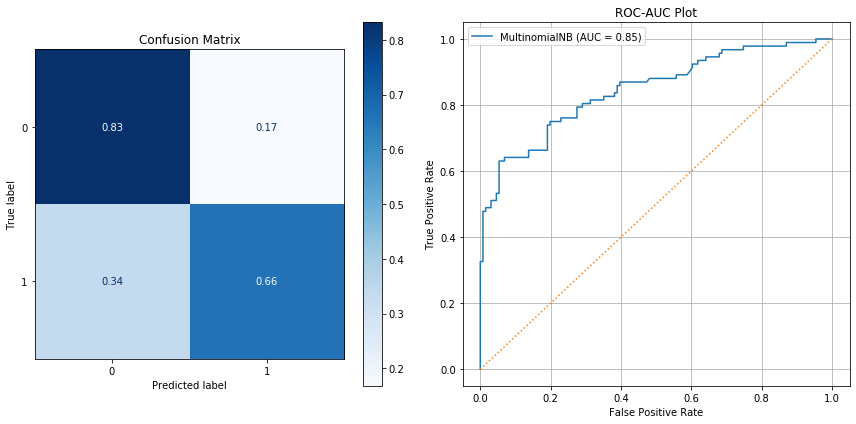

In [62]:
multinomialnb = MultinomialNB()
multinomialnb.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(multinomialnb, X_test_df, y_test)

### Suppor Vector Machine

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       131
           1       0.76      0.71      0.73        92

    accuracy                           0.78       223
   macro avg       0.78      0.77      0.78       223
weighted avg       0.78      0.78      0.78       223



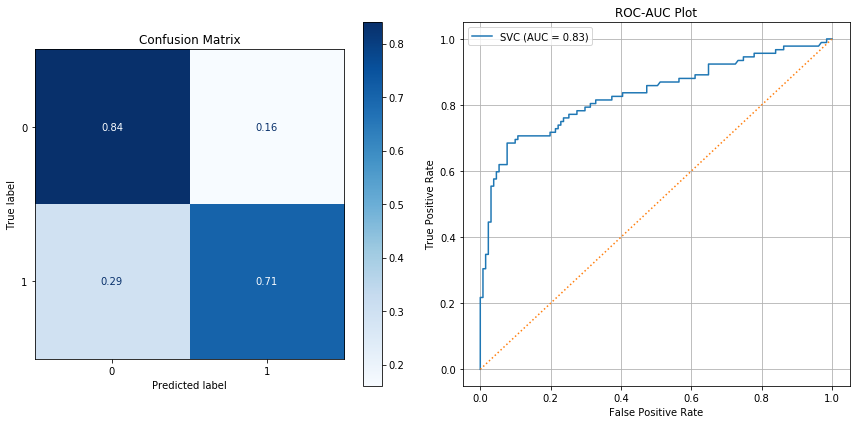

In [63]:
svc = SVC(class_weight = 'balanced')
svc.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(svc, X_test_df, y_test)

#### GridsearchCV

In [64]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'class_weight' : ['balanced'],
          'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
          'gamma': ['scale', 'auto'],
          'decision_function_shape' : ['ovo', 'ovr'],
          'C' : [0.1, 1, 10, 100, 1000],
         }

svc_grid = GridSearchCV(estimator = SVC(),
                    param_grid = params, 
                    cv = 3,
                    n_jobs = -1)

svc_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(svc_grid.best_estimator_.get_params())

{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.89      0.84       131
           1       0.81      0.70      0.75        92

    accuracy                           0.81       223
   macro avg       0.81      0.79      0.80       223
weighted avg       0.81      0.81      0.80       223



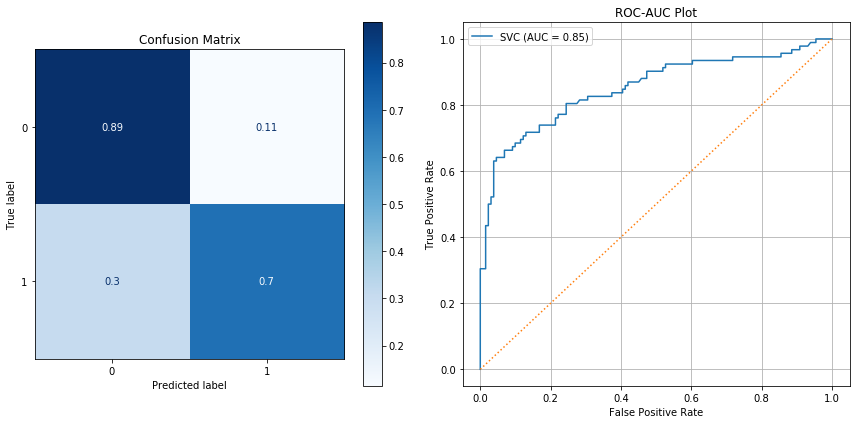

In [65]:
# Fit new model with the best hyperparameters

best_svc_params = svc_grid.best_params_
best_svc_model = SVC(**best_svc_params)
best_svc_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_svc_model, X_test_df, y_test)

### AdaBoost

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       131
           1       0.80      0.72      0.75        92

    accuracy                           0.81       223
   macro avg       0.80      0.79      0.80       223
weighted avg       0.81      0.81      0.81       223



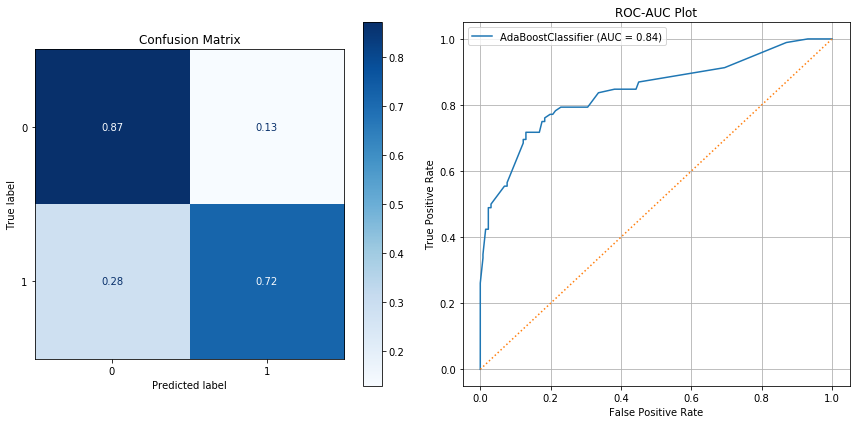

In [66]:
# Fitting a base random forest model

adaboost = AdaBoostClassifier()
adaboost.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(adaboost, X_test_df, y_test)

#### GridsearchCV

In [67]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'n_estimators' : [10, 100, 250, 500]}

ada_grid = GridSearchCV(estimator = AdaBoostClassifier(),
                    param_grid = params, 
                    cv = 3,
                    n_jobs = -1)

ada_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(ada_grid.best_estimator_.get_params())

{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': None}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       131
           1       0.80      0.70      0.74        92

    accuracy                           0.80       223
   macro avg       0.80      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223



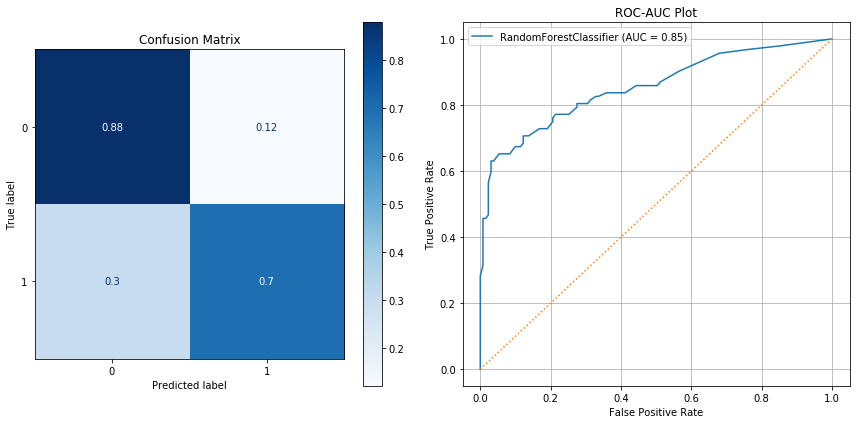

In [68]:
# Fit new model with the best hyperparameters

best_ada_params = ada_grid.best_params_
best_ada_model = RandomForestClassifier(**best_ada_params)
best_ada_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_ada_model, X_test_df, y_test)

### Random Forest

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.92      0.86       131
           1       0.86      0.71      0.77        92

    accuracy                           0.83       223
   macro avg       0.84      0.81      0.82       223
weighted avg       0.83      0.83      0.83       223



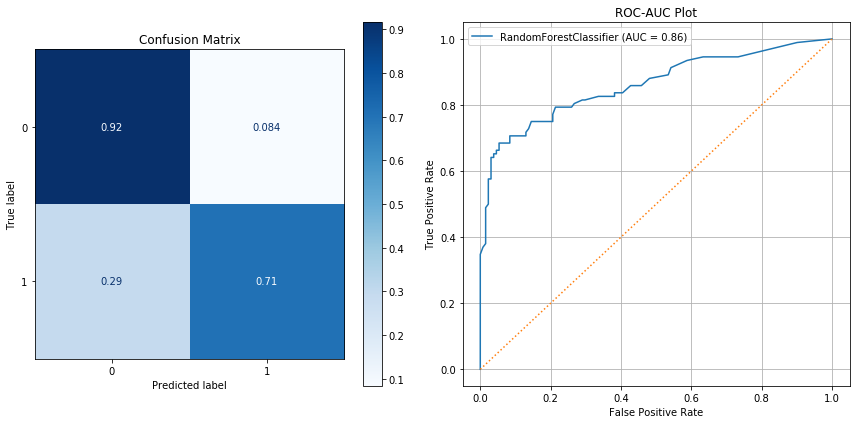

In [69]:
# Fitting a base random forest model

random_forest = RandomForestClassifier(class_weight = 'balanced')
random_forest.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(random_forest, X_test_df, y_test)

#### GridsearchCV

In [70]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'class_weight' : ['balanced', 'balanced_subsample'],
          'n_estimators' : [10, 100, 250, 500],
          'criterion': ['gini', 'entropy'],
          'max_depth' : [1, 5, 10, 25], 
          'min_samples_split' : [2, 5, 10],
          'min_samples_leaf' : [1, 5, 10]}

rf_grid = GridSearchCV(estimator = RandomForestClassifier(),
                    param_grid = params, 
                    cv = 3,
                    n_jobs = -1)

rf_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(rf_grid.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 25, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       131
           1       0.79      0.71      0.75        92

    accuracy                           0.80       223
   macro avg       0.80      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223



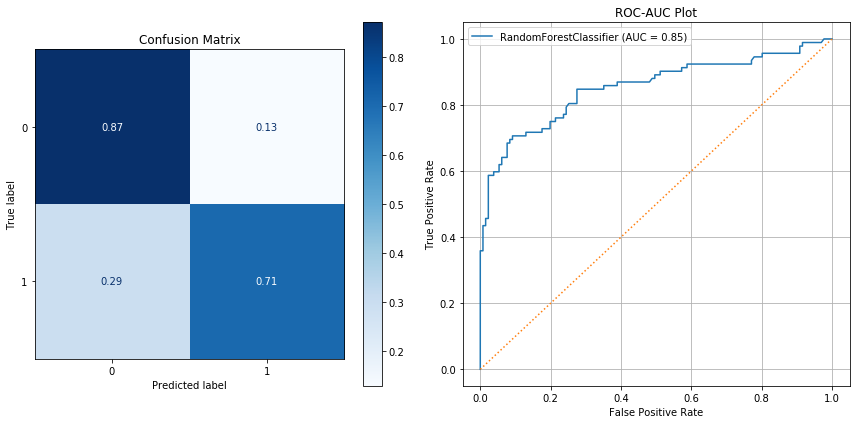

In [71]:
# Fit new model with the best hyperparameters

best_rf_params = rf_grid.best_params_
best_rf_model = RandomForestClassifier(**best_rf_params)
best_rf_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_rf_model, X_test_df, y_test)

### XGBoost

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.90      0.86       131
           1       0.83      0.71      0.76        92

    accuracy                           0.82       223
   macro avg       0.82      0.80      0.81       223
weighted avg       0.82      0.82      0.82       223



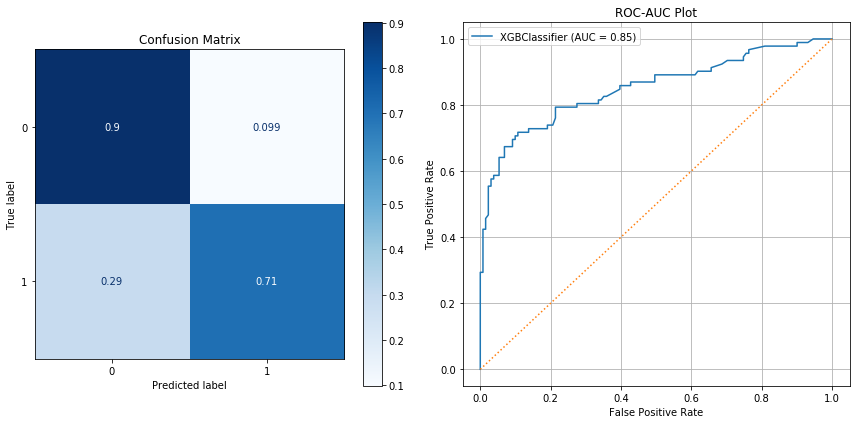

In [72]:
# Fitting a base xgboost model

xgboost = xgb.XGBClassifier()
xgboost.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(xgboost, X_test_df, y_test)

#### GridsearchCV

In [73]:
# Let's gridsearch this thing

params = {'booster': ['gbtree', 'gblinear', 'dart'],
          'gamma': [0, 0.5, 1, 2, 5],
          'max_delta_step': [0, 1, 2, 5],
          'max_depth' : [1, 5, 10, 25],
          'n_estimators': [10, 50, 100, 200]}

xgb_grid = GridSearchCV(estimator = xgb.XGBClassifier(),
                        param_grid = params, 
                        cv = 3, 
                        n_jobs = -1)

xgb_grid.fit(X_train_df, y_train)

# Check out the best parameters
print(xgb_grid.best_estimator_.get_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 25, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.92      0.86       131
           1       0.86      0.71      0.77        92

    accuracy                           0.83       223
   macro avg       0.84      0.81      0.82       223
weighted avg       0.83      0.83      0.83       223



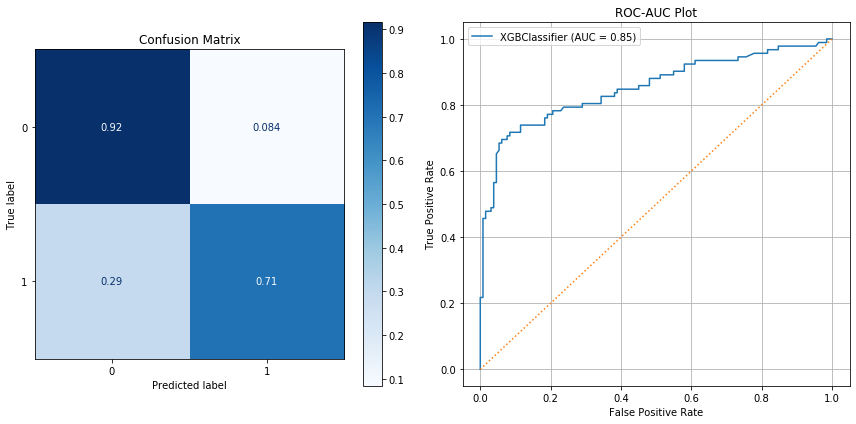

In [74]:
# Fit the model with the best parameters

best_xgb_params = xgb_grid.best_params_
best_xgb_model = xgb.XGBClassifier(**best_xgb_params)
best_xgb_model.fit(X_train_df, y_train)

# Evaluate Model
evaluate_model(best_xgb_model, X_test_df, y_test)

### Stacking Classifier

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       131
           1       0.84      0.71      0.77        92

    accuracy                           0.83       223
   macro avg       0.83      0.81      0.81       223
weighted avg       0.83      0.83      0.82       223



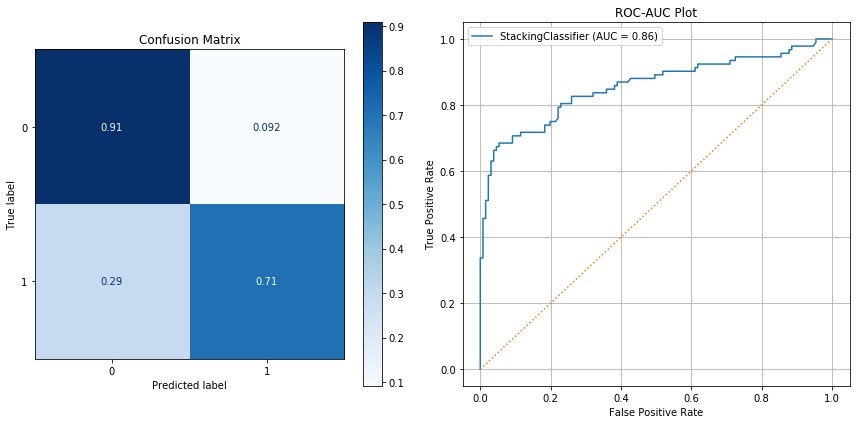

In [82]:
# Set up the stack

# Estimators made up of best performing models

estimators = [('mlp', best_mlp_model),
              ('ada', best_ada_model),
              ('rf', random_forest),
              ('svc', best_svc_model),
              ('xgb', best_xgb_model)]


# Fit the model

stack = StackingClassifier(estimators = estimators, 
                           final_estimator = LogisticRegression(),
                           cv = 5,
                           n_jobs = -1)

stack.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(stack, X_test_df, y_test)

### Voting Classifier

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       131
           1       0.82      0.71      0.76        92

    accuracy                           0.82       223
   macro avg       0.82      0.80      0.81       223
weighted avg       0.82      0.82      0.81       223



ValueError: response method decision_function or predict_proba is not defined in VotingClassifier

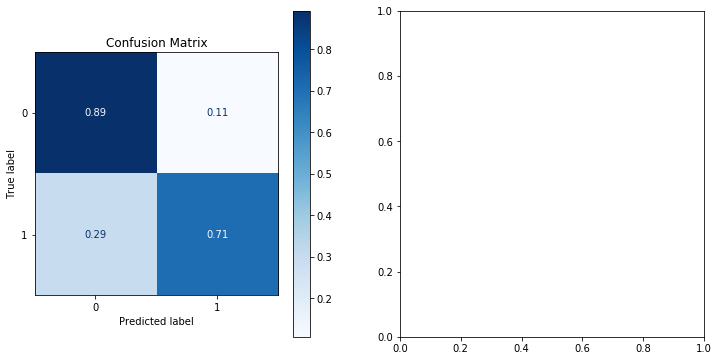

In [83]:
from sklearn.ensemble import VotingClassifier

# Estimators made up of best performing models

estimators = [('mlp', best_mlp_model),
              ('ada', best_ada_model),
              ('rf', random_forest),
              ('svc', best_svc_model),
              ('xgb', best_xgb_model)]


# Fit the model

vote = VotingClassifier(estimators = estimators, 
                           n_jobs = -1)

vote.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(vote, X_test_df, y_test)

### Deep Neural Network

#### Base Model

W0124 12:03:40.585644 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


Epoch 1/100


W0124 12:03:40.901319 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


27/30 [==========================>...] - ETA: 0s - loss: 0.6913 - accuracy: 0.6204

W0124 12:03:41.850950 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


30/30 [==============================] - 1s 23ms/step - loss: 0.6912 - accuracy: 0.6188 - val_loss: 0.6896 - val_accuracy: 0.6169
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.6552 - val_loss: 0.6646 - val_accuracy: 0.6169
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6638 - val_loss: 0.6002 - val_accuracy: 0.6716
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5856 - accuracy: 0.7388 - val_loss: 0.5136 - val_accuracy: 0.8209
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5079 - accuracy: 0.7345 - val_loss: 0.4572 - val_accuracy: 0.8209
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5130 - accuracy: 0.7602 - val_loss: 0.4595 - val_accuracy: 0.8209
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4784 - accuracy: 0.8116 - val_loss: 0.4103 - val_accuracy: 0.8507
Epoch 8/100
30/30 [=====

W0124 12:03:44.014333 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


                 Model Evaluation
-------------------------------------------------------
7/7 [==============================] - 0s 2ms/step - loss: 0.4600 - accuracy: 0.7937
[0.4600483477115631, 0.7937219738960266]
 
                 Loss & Accuracy Curves
-------------------------------------------------------


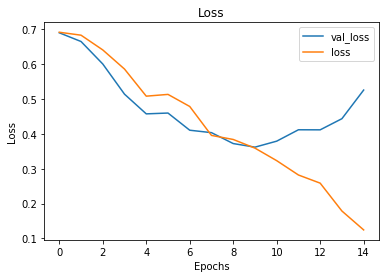

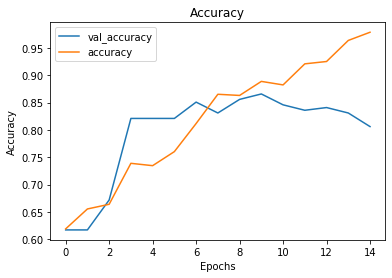

 
                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       131
           1       0.77      0.72      0.74        92

    accuracy                           0.79       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223

 
                 Confusion Matrix
-------------------------------------------------------


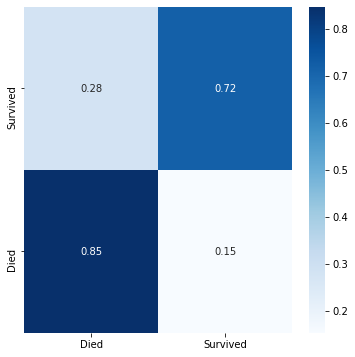

In [76]:
# Model Architecture

# Early Stopping
callback = EarlyStopping(monitor = 'val_accuracy', patience = 5, mode = 'max',
                         min_delta = 0.01, restore_best_weights = True)

# Create base model
model = Sequential()

# Input layer
model.add(Dense(128, input_shape = X_train_df.shape, activation = 'relu'))

# Hidden layers
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(8, activation = 'relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation = 'sigmoid'))

# Compile 
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')

# Fit the model
history = model.fit(X_train_df, y_train, batch_size = 16, epochs = 100,
                    validation_split = 0.3, callbacks = callback, workers = 16)

# Evaluate the model
evaluate_network(history, model, X_test_df, y_test)

#### Model with Adjusted Class Weights

In [77]:
from sklearn.utils import class_weight

In [78]:
np.unique(y_train)

array([0, 1])

In [79]:
class_weights = dict(zip(np.unique(y_train),class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                  y_train)))

W0124 12:03:46.184858 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_5_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


Epoch 1/50


W0124 12:03:46.513487 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_5_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


33/34 [============================>.] - ETA: 0s - loss: 0.5979 - accuracy: 0.7708

W0124 12:03:47.527473 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_5_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


34/34 [==============================] - 1s 21ms/step - loss: 0.5962 - accuracy: 0.7715 - val_loss: 0.5247 - val_accuracy: 0.7985
Epoch 2/50
34/34 [==============================] - 0s 4ms/step - loss: 0.5455 - accuracy: 0.7940 - val_loss: 0.5079 - val_accuracy: 0.8060
Epoch 3/50
34/34 [==============================] - 0s 4ms/step - loss: 0.5178 - accuracy: 0.8090 - val_loss: 0.4990 - val_accuracy: 0.8134
Epoch 4/50
34/34 [==============================] - 0s 4ms/step - loss: 0.5227 - accuracy: 0.8052 - val_loss: 0.4941 - val_accuracy: 0.8134
Epoch 5/50
34/34 [==============================] - 0s 4ms/step - loss: 0.5006 - accuracy: 0.8146 - val_loss: 0.4854 - val_accuracy: 0.8134
Epoch 6/50
34/34 [==============================] - 0s 4ms/step - loss: 0.4836 - accuracy: 0.8277 - val_loss: 0.4840 - val_accuracy: 0.8134
Epoch 7/50
34/34 [==============================] - 0s 4ms/step - loss: 0.4995 - accuracy: 0.8202 - val_loss: 0.4773 - val_accuracy: 0.8134
Epoch 8/50
34/34 [============

W0124 12:03:55.228044 140735779611520 functional.py:587] Model was constructed with shape (None, 668, 568) for input Tensor("dense_5_input:0", shape=(None, 668, 568), dtype=float32), but it was called on an input with incompatible shape (None, 568).


                 Model Evaluation
-------------------------------------------------------
7/7 [==============================] - 0s 2ms/step - loss: 0.5232 - accuracy: 0.7937
[0.5232160687446594, 0.7937219738960266]
 
                 Loss & Accuracy Curves
-------------------------------------------------------


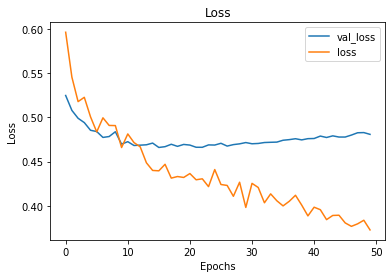

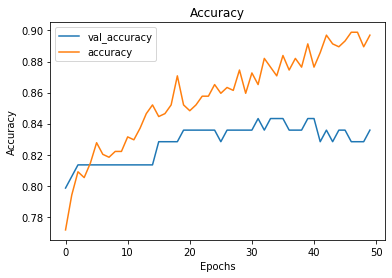

 
                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       131
           1       0.77      0.71      0.74        92

    accuracy                           0.79       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223

 
                 Confusion Matrix
-------------------------------------------------------


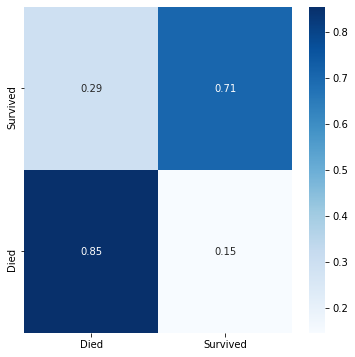

In [80]:
# Model Architecture

# Early Stopping
callback = EarlyStopping(monitor = 'val_accuracy', patience = 5, mode = 'max',
                         min_delta = 0.01, restore_best_weights = True)

# Create base model
model = Sequential()

# Input layer
model.add(Dense(256, input_shape = X_train_df.shape, activation = 'tanh', 
                kernel_initializer = 'constant', kernel_regularizer = tf.keras.regularizers.L1(0.001),
                activity_regularizer = tf.keras.regularizers.L2(0.001)))

# Hidden layers
model.add(Dense(128, activation = 'selu'))
model.add(Dropout(0.3))

model.add(Dense(64, activation = 'selu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation = 'selu'))
model.add(Dropout(0.3))

model.add(Dense(16, activation = 'selu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation = 'sigmoid'))

# Compile 
model.compile(optimizer = 'adagrad', loss = 'binary_crossentropy', metrics = 'accuracy')

# Fit the model
history = model.fit(X_train_df, y_train, batch_size = 16, epochs = 50,
                    validation_split = 0.2, class_weight = class_weights, 
                    workers = 16)#, callbacks = callback)

# Evaluate the model
evaluate_network(history, model, X_test_df, y_test)

## Interpret

### Feature Importances

In [90]:
features_dict = {'Features': X_train_df.columns,
                 'Importance': best_xgb_model.feature_importances_}

features_df = pd.DataFrame(features_dict, columns = ['Features', 'Importance'])

features_df.sort_values(by = 'Importance', ascending = False)

,Features,Importance
29,Title_ Mr,0.429300
32,Title_ Rev,0.124880
0,Pclass,0.079942
53,Last Name_Asplund,0.068151
22,Title_ Dr,0.047757
...,...,...
196,Last Name_Frolicher,0.000000
195,Last Name_Frauenthal,0.000000
194,Last Name_Francatelli,0.000000
193,Last Name_Fortune,0.000000


In [91]:
for i in features_df['Importance']:
    if i == 0:
        features_df['Importance'].replace(i, np.nan, inplace = True)
        
features_df.dropna(inplace = True)

features_df.sort_values(by = 'Importance', ascending = False)

,Features,Importance
29,Title_ Mr,0.429300
32,Title_ Rev,0.124880
0,Pclass,0.079942
53,Last Name_Asplund,0.068151
22,Title_ Dr,0.047757
5,Family Size,0.030847
15,Cabin Level_E,0.030082
6,Sex_female,0.025749
18,Cabin Level_M,0.018469
4,Fare,0.015332


In [85]:
import shap

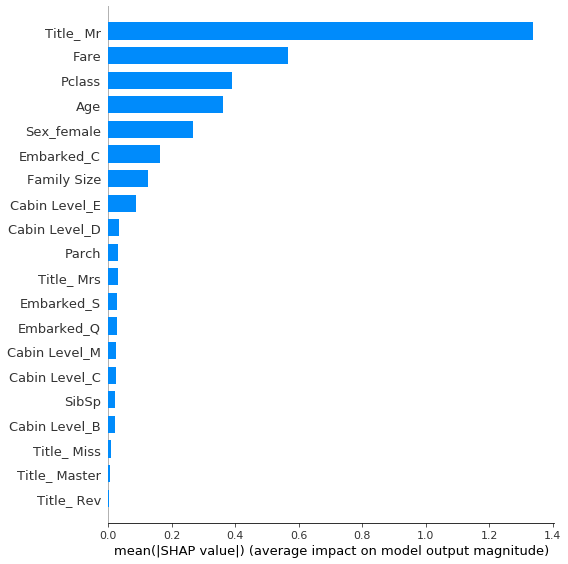

In [92]:
X_shap = shap.sample(X_test_df, 100)
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_shap)

# Plotting a summary plot
fig = shap.summary_plot(shap_values, X_shap, plot_type = 'bar')

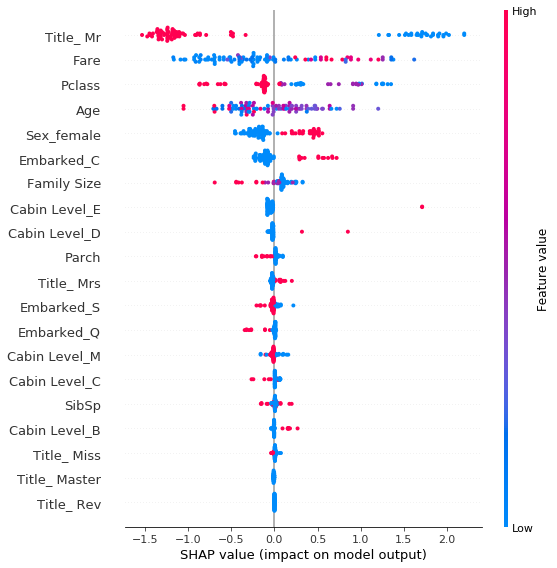

In [93]:
# The shap feature importances plot

shap.summary_plot(shap_values, X_shap)

## Conclusion